In [57]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy

In [2]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(2)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml16-ne64-do1

/tmp/ipykernel_3703738/3314320431.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
# best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_micro.pt", map_location=device)
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Repeat@5-AttnMask-UnlabelValid-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_macro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_3703738/307592194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/b

<All keys matched successfully>

In [85]:
class GittablesTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)

            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
            else:
                cur_maxlen = max(1, max_length // len(list(group_df["class_id"].values)) - 1)
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [86]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [90]:
src = None
test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [11]:
train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

train 1
train 2
train 3
train 4
train 3463


In [78]:

model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5355, ts_macro_f1=0.2745
ts_micro_f1=0.5351, ts_macro_f1=0.2745
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [89]:
for max_unlabeled in [1, 2, 4]:
    print(f"************************** max_unlabeled={max_unlabeled} **************************")
    src = None
    test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                max_unlabeled = max_unlabeled,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1")
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_iter = DataLoader(test_dataset_iter,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(batch["target_col_mask"].max().item())
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

************************** max_unlabeled=1 **************************
test
test 1085
ts_micro_f1=0.4876, ts_macro_f1=0.2104
ts_micro_f1=0.4818, ts_macro_f1=0.2082
ts_micro_f1=0.4941, ts_macro_f1=0.1724
************************** max_unlabeled=2 **************************
test
test 1085
ts_micro_f1=0.5014, ts_macro_f1=0.2123
ts_micro_f1=0.5009, ts_macro_f1=0.2123
ts_micro_f1=1.0000, ts_macro_f1=1.0000
************************** max_unlabeled=4 **************************
test
test 1085
ts_micro_f1=0.5235, ts_macro_f1=0.2501
ts_micro_f1=0.5231, ts_macro_f1=0.2501
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [83]:
batch.keys()

dict_keys(['data', 'label', 'cls_indexes'])

In [79]:
num_cols

tensor([3, 3, 7,  ..., 7, 7, 2])

<Axes: ylabel='Count'>

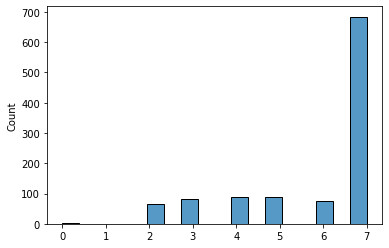

In [80]:
import seaborn as sns
sns.histplot(num_cols)

In [81]:
(num_cols<7).sum().item()/len(num_cols)

0.3695852534562212

In [12]:
class_freq = torch.zeros(args.num_classes)
for batch_idx, batch in enumerate(train_dataloader_iter):
    class_freq[batch["label"].item()] += 1

In [13]:
# def reweight_logits(logits, class_weights):
#     # Reweight the logits by multiplying with class weights
#     reweighted_logits = logits * torch.sqrt(class_weights)
    
#     # Apply softmax to the reweighted logits
#     reweighted_probs = F.softmax(reweighted_logits, dim=-1)
    
#     return reweighted_probs
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [55]:
def reweight_logits_after_softmax(logits, class_weights):
    # Step 1: Apply exp(logits)
    probs = F.softmax(logits, dim=-1)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_probs = probs * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_probs / reweighted_probs.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [141]:
labels_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    labels_test.append(batch["label"].cpu().item())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.Tensor(labels_test).long()
num_cols = torch.tensor(num_cols)
labels_test = labels_test[num_cols>0]
num_cols = num_cols[num_cols>0]

In [105]:
(num_cols==0).sum().item()

1

In [114]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
round_msp_predict = defaultdict(list)
ood_score_round_msp = defaultdict(list)
final_msp_round = []
correct_permutation_round = []

msp_predicts = []
max_col_length = 3

alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 1.0
# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    logits_test = []
    log = defaultdict(list)
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            correct_permutation_round_i = 0
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            
            for r in range(len(init_permutation_i)-1, 1, -1):
                round_msp = 0
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    if not is_sublist(x, init_permutation_i):
                        continue
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    if 0 not in x:
                        cls_indexes_value = 0
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                    msp_temp = logits_temp.max().item()
                    predict_temp = logits_temp.argmax().item()
                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                    #     debias_class.append(predict_temp)
                    #     continue
                    # print(x, msp_temp, predict_temp)
                    # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                    if msp_temp > max_msp and 0 in x:
                        max_msp = msp_temp
                        msp_predict = predict_temp
                    if msp_temp > round_msp:
                        round_msp = msp_temp
                        round_msp_predict_i= predict_temp
                    if predict_temp == batch["label"].item():
                        if not correct_permutation:
                            correct_permutation_round_i = len(init_permutation_i)-r
                        correct_permutation = True
                        if msp_temp > correct_permutation_ood_score:
                            correct_permutation_ood_score = msp_temp
                round_msp_predict[len(init_permutation_i)-r].append(round_msp_predict_i)
                ood_score_round_msp[len(init_permutation_i)-r].append(round_msp)
            correct_permutation_round.append(correct_permutation_round_i)
            final_msp_round.append(len(init_permutation_i)-r)
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.9****************************


In [115]:
round_msp_predict.keys()

dict_keys([1, 2, 3, 4, 5, 6])

0.7232472324723247


<Axes: ylabel='Count'>

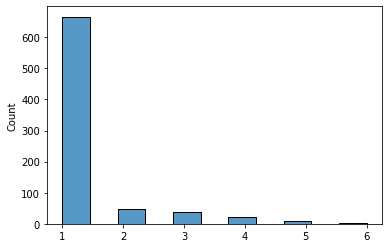

In [121]:
print(len(correct_permutation_round[correct_permutation_mask])/len(correct_permutation_mask))
sns.histplot(correct_permutation_round[correct_permutation_mask])

<Axes: ylabel='Count'>

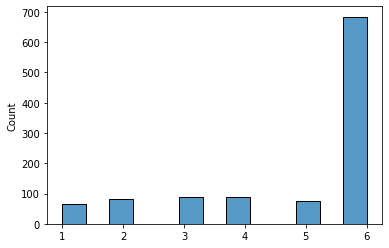

In [117]:
sns.histplot(final_msp_round)

<Axes: ylabel='Count'>

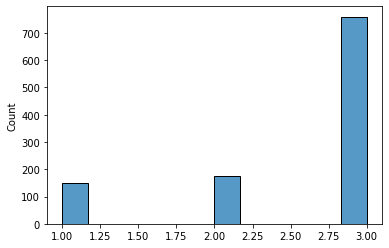

In [112]:
sns.histplot(final_msp_round)

In [100]:
round_msp_predict.keys()

dict_keys([1, 2, 3])

In [107]:
num_cols[0]

tensor(3)

In [113]:
# TODO: maybe shorter columns are easier to predict 
print(correct_init_mask.sum().item()/len(correct_init_mask))
print(len(correct_msp_mask), correct_msp_mask.sum().item()/len(correct_msp_mask))
for round in round_msp_predict.keys():
    print(f"round={round}")
    round_mask_temp = [(value- (value+1)//2)>(round-1) for value in num_cols]
    print(sum(round_mask_temp),sum(torch.Tensor(round_msp_predict[round]).reshape(-1)==labels_test[round_mask_temp])/len(round_msp_predict[round])
    )


0.5313653136531366
1084 0.518450184501845
round=1
tensor(1084) tensor(0.5332)
round=2
tensor(935) tensor(0.5251)
round=3
tensor(759) tensor(0.5046)


In [126]:
print(len(correct_init_mask), len(num_cols))

1084 1085


In [128]:
num_cols = num_cols[num_cols>0]
for i in num_cols.unique():
    mask = num_cols == i
    correct_init_mask_i = correct_init_mask[mask]
    print(i, len(correct_init_mask_i), correct_init_mask_i.sum()/len(correct_init_mask_i))

tensor(2) 66 tensor(0.6364)
tensor(3) 83 tensor(0.5060)
tensor(4) 88 tensor(0.5795)
tensor(5) 88 tensor(0.5455)
tensor(6) 75 tensor(0.5733)
tensor(7) 684 tensor(0.5117)


In [136]:
round_msp_predict.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [139]:
num_cols.shape

torch.Size([1084])

In [140]:
labels_test.shape

torch.Size([1085])

In [142]:
# TODO: maybe shorter columns are easier to predict 
print(correct_init_mask.sum().item()/len(correct_init_mask))
print(len(correct_msp_mask), correct_msp_mask.sum().item()/len(correct_msp_mask))
for round in round_msp_predict.keys():
    print(f"round={round}")
    round_mask_temp = [(value- 1)>(round-1) for value in num_cols]
    print(sum(round_mask_temp),sum(torch.Tensor(round_msp_predict[round]).reshape(-1)==labels_test[round_mask_temp])/len(round_msp_predict[round])
    )

0.5313653136531366
1084 0.49723247232472323
round=1
tensor(1084) tensor(0.5332)
round=2
tensor(1018) tensor(0.5236)
round=3
tensor(935) tensor(0.5091)
round=4
tensor(847) tensor(0.4841)
round=5
tensor(759) tensor(0.4862)
round=6
tensor(684) tensor(0.4532)


In [164]:
# TODO
for num_col in num_cols.unique():
    print(f"**********************num_col={num_col}, num {(num_cols == num_col).sum().item()}****************************")
    mask = num_cols == num_col
    print("Init:", correct_init_mask[mask].sum().item()/len(correct_init_mask[mask]))
    print("MSP final", len(correct_msp_mask[mask]), correct_msp_mask[mask].sum().item()/len(correct_msp_mask[mask]))
    for round in round_msp_predict.keys():
        if round > num_col-1:
            continue
        print(f"round={round}")
        round_mask_temp = torch.tensor([(value- 1)>(round-1) for value in num_cols])
        round_mask_for_predict = round_mask_temp[mask]
        print(sum(round_mask_temp&mask),sum(torch.Tensor(round_msp_predict[round]).reshape(-1)[mask][round_mask_for_predict]==labels_test[round_mask_temp&mask])/len(torch.Tensor(round_msp_predict[round]).reshape(-1)[mask][round_mask_for_predict])
        )

**********************num_col=2, num 66****************************
Init: 0.6363636363636364
MSP final 66 0.5606060606060606
round=1
tensor(66) tensor(0.5606)
**********************num_col=3, num 83****************************
Init: 0.5060240963855421
MSP final 83 0.5301204819277109
round=1
tensor(83) tensor(0.5301)
round=2


IndexError: The shape of the mask [1084] at index 0 does not match the shape of the indexed tensor [1018] at index 0

In [170]:
round_mask_temp.shape

torch.Size([1084])

In [169]:
round_mask_for_predict.shape

torch.Size([83])

In [168]:
len(torch.Tensor(round_msp_predict[round]).reshape(-1)[round_mask_for_predict])

IndexError: The shape of the mask [83] at index 0 does not match the shape of the indexed tensor [1018] at index 0

In [161]:
sum(torch.Tensor(round_msp_predict[round]).reshape(-1)[mask][round_mask_for_predict]==labels_test[round_mask_temp])

RuntimeError: The size of tensor a (66) must match the size of tensor b (1084) at non-singleton dimension 0

In [163]:
labels_test[round_mask_temp].shape

torch.Size([1084])

In [155]:
torch.Tensor(round_msp_predict[round]).reshape(-1)[mask].shape

torch.Size([66])

In [152]:
torch.Tensor(round_msp_predict[round]).reshape(-1).shape

torch.Size([1084])

In [149]:
round_mask_temp.shape

torch.Size([1084])

In [150]:
mask.shape

torch.Size([1084])

In [134]:
torch.Tensor(round_msp_predict[round]).reshape(-1).shape

torch.Size([1084])

In [135]:
labels_test[round_mask_temp].shape

IndexError: The shape of the mask [1084] at index 0 does not match the shape of the indexed tensor [1085] at index 0

In [138]:
labels_test.shape

torch.Size([1085])

In [119]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
correct_permutation_round = torch.tensor(correct_permutation_round).reshape(-1)

msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
# torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

1084 0 1084 0 1084


In [30]:
# weighted, only uncertain init

for threshold in [0.80, 0.82, 0.83, 0.84, 0.85, 0.9]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.8****************************
Init
528 758 0.6965699208443272
48 326 0.147239263803681
MSP
503 758 0.6635883905013192
59 326 0.18098159509202455
MSP & Init
482
549 758 0.7242744063324539
85 326 0.2607361963190184
Permutation
609 758 0.8034300791556728
141 326 0.4325153374233129
Permutation Confident
567 758 0.7480211081794196
81 326 0.24846625766871167
*********************Threshold: 0.82****************************
Init
524 742 0.706199460916442
52 342 0.15204678362573099
MSP
497 742 0.6698113207547169
65 342 0.19005847953216373
MSP & Init
479
542 742 0.7304582210242587
92 342 0.26900584795321636
Permutation
599 742 0.807277628032345
151 342 0.4415204678362573
Permutation Confident
558 742 0.7520215633423181
88 342 0.2573099415204678
*********************Threshold: 0.83****************************
Init
523 736 0.7105978260869565
53 348 0.15229885057471265
MSP
496 736 0.6739130434782609
66 348 0.1896551724137931
MSP & Init
478
541 736 0.735054347826086

In [31]:
# weighted, only uncertain init

for threshold in [0.82]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.82****************************
Init
524 742 0.706199460916442
52 342 0.15204678362573099
MSP
497 742 0.6698113207547169
65 342 0.19005847953216373
MSP & Init
479
542 742 0.7304582210242587
92 342 0.26900584795321636
Permutation
599 742 0.807277628032345
151 342 0.4415204678362573
Permutation Confident
558 742 0.7520215633423181
88 342 0.2573099415204678


In [32]:
# MSP is wrong, but init is correct
target_col_idx_msp_init = idx_list[~condition_mask&correct_msp_mask&correct_init_mask]
target_col_idx_msp =  idx_list[~condition_mask&correct_msp_mask&~correct_init_mask]
target_col_idx_init =  idx_list[~condition_mask&~correct_msp_mask&correct_init_mask]
target_col_idx_permutation = idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask]
target_col_idx_permutation_msp =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask]
target_col_idx_permutation_init =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_init_mask]

print("Both correct", (~condition_mask&correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(), 
      # ood_score_target_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(),
      ood_score_final_list[~condition_mask&correct_msp_mask&correct_init_mask].mean())
print("MSP correct ", (~condition_mask&correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean())
print("Init correct", (~condition_mask&~correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean())
print("Permutation correct",(~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean())

Both correct tensor(25) tensor(0.6187) tensor(0.9433)
MSP correct  tensor(40) tensor(0.5216) tensor(0.9643)
Init correct tensor(27) tensor(0.5349) tensor(0.9423)
Permutation correct tensor(13) tensor(0.5649) tensor(0.9761)


In [67]:
threshold

0.8

In [33]:
target_col_idx_permutation_msp
# imbalance: 21, 52, 59, 154, 265, 275, 286
# early stop: 21, 59, 246, 275
# not imformative: 118, 138, 154， 286
# todo: 287

tensor([  21,   52,   59,  118,  138,  154,  246,  265,  273,  275,  286,  287,
         296,  325,  372,  419,  433,  568,  610,  643,  743,  808,  894,  929,
         989, 1042, 1075])

In [74]:
# use target as head, the MSP context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
max_col_length = 3
msp_threshold = 0.9


alpha = 1.0

class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataset_iter):
    if batch_idx == 21:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
col_idx_set = target_col_mask.unique().tolist()
init_permutation_i = get_permutation(target_col_mask)
successs = False
# logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
# logits = reweight_logits(logits, class_weights)
# logits_init = logits.clone()
# num_cols.append(batch["target_col_mask"].max().item())


# col_idx_set = target_col_mask.unique().tolist()
# successs = False
# init_permutation_i = get_permutation(target_col_mask)
# init_permutation[batch_idx].append(get_permutation(target_col_mask))
# init_logits[batch_idx].append(logits_init.detach().cpu())     
# init_msp = logits_init.max().item()
# print(batch["label"].item())
# print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item()) 
print(batch["label"].item())  
print(batch["target_col_mask"].max().item(), get_permutation(target_col_mask))
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
# for r in range(1, min(len(col_idx_set), max_col_length) + 1):
enough = False
# for r in range(len(col_idx_set)-1, 0, -1):
for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset and r != 1:
            continue
        for x in itertools.permutations(subset):
            if not is_sublist(x, init_permutation_i):
                continue
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max()
            predict_temp = logits_temp.argmax()
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()

            print(x, msp_temp,predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
        
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

28
7 [1, 2, 3, 0, 4, 5, 6, 7]
********************************************************
(1, 2, 3, 0, 4, 5, 6) tensor(0.6667) tensor(28)
(1, 2, 3, 0, 4, 5, 7) tensor(0.7467) tensor(28)
(1, 2, 3, 0, 4, 6, 7) tensor(0.6455) tensor(28)
(1, 2, 3, 0, 5, 6, 7) tensor(0.7037) tensor(28)
(1, 2, 0, 4, 5, 6, 7) tensor(0.2869) tensor(62)
(1, 3, 0, 4, 5, 6, 7) tensor(0.1574) tensor(90)
(2, 3, 0, 4, 5, 6, 7) tensor(0.1626) tensor(62)
(1, 2, 3, 0, 4, 5) tensor(0.6485) tensor(28)
(1, 2, 3, 0, 4, 6) tensor(0.7471) tensor(28)
(1, 2, 3, 0, 4, 7) tensor(0.2197) tensor(95)
(1, 2, 3, 0, 5, 6) tensor(0.6111) tensor(28)
(1, 2, 3, 0, 5, 7) tensor(0.2820) tensor(28)
(1, 2, 3, 0, 6, 7) tensor(0.2656) tensor(95)
(1, 2, 0, 4, 5, 6) tensor(0.3814) tensor(28)
(1, 2, 0, 4, 5, 7) tensor(0.1848) tensor(62)
(1, 2, 0, 4, 6, 7) tensor(0.2487) tensor(62)
(1, 2, 0, 5, 6, 7) tensor(0.2260) tensor(28)
(1, 3, 0, 4, 5, 6) tensor(0.6227) tensor(51)
(1, 3, 0, 4, 5, 7) tensor(0.2212) tensor(95)
(1, 3, 0, 4, 6, 7) tensor(0.2318) ten

In [64]:
# use target as head, the MSP context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
max_col_length = 3
msp_threshold = 0.9


alpha = 1.0

class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataset_iter):
    if batch_idx == 287:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
col_idx_set = target_col_mask.unique().tolist()
init_permutation_i = get_permutation(target_col_mask)
successs = False
# logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
# logits = reweight_logits(logits, class_weights)
# logits_init = logits.clone()
# num_cols.append(batch["target_col_mask"].max().item())


# col_idx_set = target_col_mask.unique().tolist()
# successs = False
# init_permutation_i = get_permutation(target_col_mask)
# init_permutation[batch_idx].append(get_permutation(target_col_mask))
# init_logits[batch_idx].append(logits_init.detach().cpu())     
# init_msp = logits_init.max().item()
# print(batch["label"].item())
# print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item()) 
print(batch["label"].item())  
print(batch["target_col_mask"].max().item(), get_permutation(target_col_mask))
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
# for r in range(1, min(len(col_idx_set), max_col_length) + 1):
enough = False
# for r in range(len(col_idx_set)-1, 0, -1):
for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset and r != 1:
            continue
        for x in itertools.permutations(subset):
            if not is_sublist(x, init_permutation_i):
                continue
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            logits_temp = reweight_logits_after_softmax(logits_temp, class_weights)
            msp_temp = logits_temp.max()
            predict_temp = logits_temp.argmax()
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()

            print(x, msp_temp,predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
        
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

17
7 [1, 2, 3, 4, 5, 6, 7, 0]
********************************************************
(1, 2, 3, 4, 5, 6, 0) tensor(0.9756) tensor(2)
(1, 2, 3, 4, 5, 7, 0) tensor(0.9756) tensor(2)
(1, 2, 3, 4, 6, 7, 0) tensor(0.9892) tensor(2)
(1, 2, 3, 5, 6, 7, 0) tensor(0.9861) tensor(2)
(1, 2, 4, 5, 6, 7, 0) tensor(0.8058) tensor(2)
(1, 3, 4, 5, 6, 7, 0) tensor(0.9832) tensor(2)
(2, 3, 4, 5, 6, 7, 0) tensor(0.9849) tensor(2)
(1, 2, 3, 4, 5, 0) tensor(0.9788) tensor(17)
(1, 2, 3, 4, 6, 0) tensor(0.6931) tensor(2)
(1, 2, 3, 4, 7, 0) tensor(0.8591) tensor(17)
(1, 2, 3, 5, 6, 0) tensor(0.4576) tensor(17)
(1, 2, 3, 5, 7, 0) tensor(0.9128) tensor(17)
(1, 2, 3, 6, 7, 0) tensor(0.9318) tensor(17)
(1, 2, 4, 5, 6, 0) tensor(0.9621) tensor(17)
(1, 2, 4, 5, 7, 0) tensor(0.8874) tensor(17)
(1, 2, 4, 6, 7, 0) tensor(0.9143) tensor(17)
(1, 2, 5, 6, 7, 0) tensor(0.9435) tensor(17)
(1, 3, 4, 5, 6, 0) tensor(0.6641) tensor(2)
(1, 3, 4, 5, 7, 0) tensor(0.9132) tensor(17)
(1, 3, 4, 6, 7, 0) tensor(0.9250) tensor(17)
(

In [69]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [ 0.8, 0.9, 0.99]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.5429, ts_macro_f1=0.2641
ts_micro_f1=0.5424, ts_macro_f1=0.2641
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5419, ts_macro_f1=0.2632
ts_micro_f1=0.5415, ts_macro_f1=0.2632
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.99****************************
ts_micro_f1=0.5382, ts_macro_f1=0.2665
ts_micro_f1=0.5378, ts_macro_f1=0.2665
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [71]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [ 0.0]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.8; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5419, ts_macro_f1=0.2611
ts_micro_f1=0.5415, ts_macro_f1=0.2610
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [72]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.9]:
        for msp_threshold in [ 0.0, 0.8, 0.85, 0.9, 0.99]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.0****************************
ts_micro_f1=0.5429, ts_macro_f1=0.2634
ts_micro_f1=0.5424, ts_macro_f1=0.2634
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.5438, ts_macro_f1=0.2665
ts_micro_f1=0.5434, ts_macro_f1=0.2665
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.85****************************
ts_micro_f1=0.5419, ts_macro_f1=0.2636
ts_micro_f1=0.5415, ts_macro_f1=0.2636
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.5429, ts_macro_f1=0.2655
ts_micro_f1=0.5424, ts_macro_f1=0.2655
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.99****************************
ts_micro_f1=0.5392, ts_ma